In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pywt.data
from sklearn import cluster
import cv2

In [ ]:
!wget https://github.com/PK0TA/DATA/raw/main/IVP/lenna.png

--2021-11-07 18:46:30--  https://github.com/PK0TA/DATA/raw/main/IVP/lenna.png
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/PK0TA/DATA/main/IVP/lenna.png [following]
--2021-11-07 18:46:31--  https://raw.githubusercontent.com/PK0TA/DATA/main/IVP/lenna.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473831 (463K) [image/png]
Saving to: ‘lenna.png’

lenna.png           100%[===================>] 462.73K  --.-KB/s    in 0.01s   

2021-11-07 18:46:31 (35.8 MB/s) - ‘lenna.png’ saved [473831/473831]



In [ ]:
#Vector Quantization Algorithm
def VectorQuantization(image):
    original = np.float32(image)
    X = original.reshape((-1, 1))
    k_means = cluster.KMeans(n_clusters=n_clusters, n_init=4)
    k_means.fit(X)
    values = k_means.cluster_centers_.squeeze()
    labels = k_means.labels_

    image_compressed = np.choose(labels, values)
    image_compressed.shape = original.shape

    vmin = original.min()
    vmax = original.max()

    return image_compressed,vmin,vmax

In [ ]:
# Read Image and convert it to Grayscale Image
image = cv2.imread('/content/lenna.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

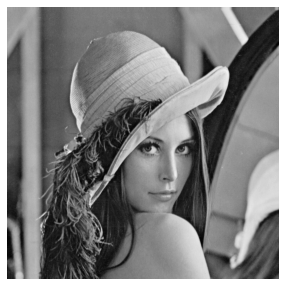

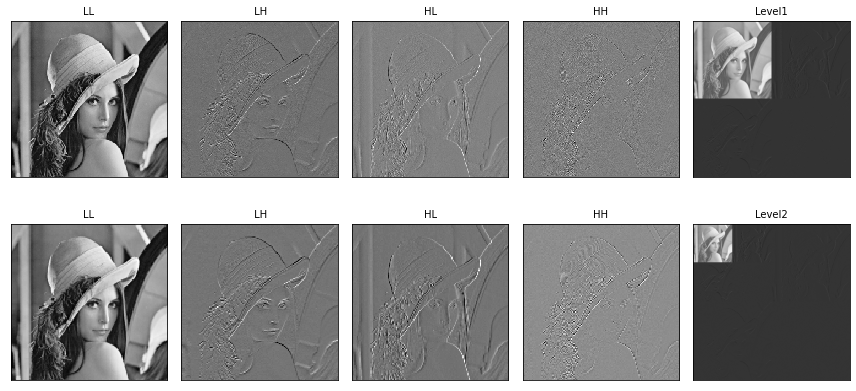

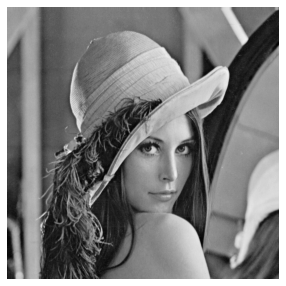

PSNR = 27.609603867255565


In [ ]:

#Store a copy of image for psnr reference
original = np.float32(image)
original /= 255
original *= 255
original = np.uint8(original)

plt.figure(1, figsize=(5, 5))
plt.imshow(original, cmap=plt.cm.gray)
plt.axis('off')

titles = ['LL', ' LH','HL', 'HH']

#Set levels of decomposition
Level = 2

fig, ax = plt.subplots(Level, 5,figsize=(12, Level * (4 - Level + 1)))

LL = original

#Create Cofficients List of arrays
List_DWT = []

#Algorithm to compute DWT for Different Levels
for level in range(Level):
    coeffs2 = pywt.dwt2(LL, 'haar')
    LL, (LH, HL, HH) = coeffs2
    for i, a in enumerate([LL, LH, HL, HH]):
        if Level == 1:
            plot = ax[i]
        else:
            plot = ax[level, i]
        plot.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
        plot.set_title(titles[i], fontsize=10)
        plot.set_xticks([])
        plot.set_yticks([])
        if i == 0:
            LL = a
        elif i == 1:
            LH = a
        elif i == 2:
            HL = a
        elif i == 3:
            HH = a
    List_DWT.append((LH, HL, HH))

    #Set Cluster Size for Vector Quantization
    n_clusters = 3
    np.random.seed(0)
    coeffs_list = []
    for i in List_DWT:
        coeffs_list.append(i)
        j_arr = []
        for j in i:
            j,vmin,vmax = VectorQuantization(j)
            j_arr.append(j)
    coeffs_list.append(LL)
    coeffs_list.reverse()

    #Compile The Subbands of image generated
    arr, slices = pywt.coeffs_to_array(coeffs_list)
    if Level == 1:
        plot = ax[4]
    else:
        plot = ax[level, 4]
    #Display the resultant image
    plot.imshow(arr, cmap=plt.cm.gray)
    plot.set_title("Level" + str(level+1), fontsize=10)
    plot.set_xticks([])
    plot.set_yticks([])

cv2.imwrite("arr.jpg",arr)
plt.figure(3, figsize=(5, 5))

#Reconstruct the image
rec_image = pywt.waverec2(coeffs_list, 'haar')
# Display Reconstructed image
cv2.imwrite("Reconstructed.jpg",rec_image)
plt.imshow(rec_image, cmap=plt.cm.gray)
plt.axis('off')

fig.tight_layout()
plt.show()

# Calculate PSNR of original and reconstructed image
original = cv2.imread("lenna.png")
reconstructed = cv2.imread("Reconstructed.jpg",1)
def psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

print("PSNR = " + str(psnr(original,reconstructed)))